In [1]:
import pandas as pd
import numpy as np
from numpy.random import randint
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import (
    OneHotEncoder,
    QuantileTransformer,
    RobustScaler,
    LabelEncoder,
    MinMaxScaler,
)
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import (
    balanced_accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report,
    accuracy_score,
    make_scorer,
    cohen_kappa_score,
    f1_score
)
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from imblearn import pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
from sklearn.feature_selection import RFE

In [2]:
sns.set_theme()
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
colors = ["#e60c34ff", "#fda92995", "#19ae1dff"]
colors_w = ["#5798ff", "#c2006b"]

In [3]:
# Import the CSVs
wine = pd.read_csv('data/processed/wine.csv', sep=',')
rw = pd.read_csv('data/processed/red_wine_p.csv', sep=',')
ww = pd.read_csv('data/processed/white_wine_p.csv', sep=',')


In [4]:
# Convert 'wine type' to categorical data
wine['wine type'] = wine['wine type'].astype('category')
rw['quality label'] = pd.Categorical(rw['quality label'], categories=['low', 'medium', 'high'], ordered=True)
ww['quality label'] = pd.Categorical(ww['quality label'], categories=['low', 'medium', 'high'], ordered=True)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density'],
      dtype='object')
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       290
           1       0.99      0.99      0.99       774

    accuracy                           0.99      1064
   macro avg       0.99      0.98      0.98      1064
weighted avg       0.99      0.99      0.99      1064

[[283   7]
 [  6 768]]


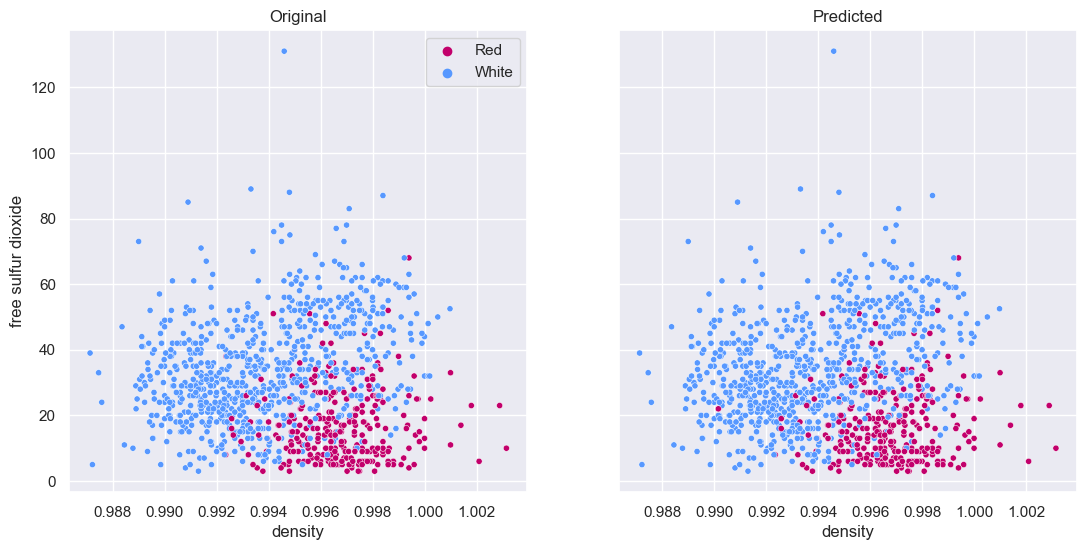

In [5]:
# Function for predicting wine type

def predict_type(data):
    # Encode wine types 'red' and 'white' into 1 and 0
    y = data["wine type"].cat.codes.copy()

    # Pick the first 8 columns (features) from the dataset            
    X = data.iloc[:, list(range(0, 8))].copy()
    print(X.columns)

    # display(pd.concat([X, y], join='outer', axis=1))

    # Split the dataset into 80% training data and 20% testing data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    # Create ML pipeline
    pipe = Pipeline([
            # Using QuantileTransformer to reduce outliers influence 
            ("scaler", QuantileTransformer()),
            # Model is a ML Algorithm, Logistic Regression is good for binary classification
            ("model", LogisticRegression(max_iter=1000)),
        ])

    # Train the model (or pipe) on the training data using fir method
    pipe.fit(X_train, y_train)
    # Predict the type on testing data
    pred = pipe.predict(X_test)

    print(classification_report(pred, y_test))
    print(confusion_matrix(pred, y_test))

    # Plot the results
    fig, axes = plt.subplots(1, 2, figsize=(13, 6), sharey=True)
    sns.scatterplot(
        x=X_test.iloc[:, 7],
        y=X_test.iloc[:, 5],
        hue=y_test,
        ax=axes[0],
        palette=colors_w[::-1],
        s=20,
    )
    axes[0].set_title('Original')
    sns.scatterplot(
        x=X_test.iloc[:, 7],
        y=X_test.iloc[:, 5],
        hue=pred,
        ax=axes[1],
        palette=colors_w[::-1],
        s=20,
    )
    L=axes[0].legend()
    L.get_texts()[0].set_text('Red')
    L.get_texts()[1].set_text('White')
    axes[1].set_title('Predicted')
    axes[1].legend([], [], frameon=False)

predict_type(wine)

In [6]:
def custom_precision(y_true, y_pred):
        precision = precision_score(y_true, y_pred)
        return precision if not np.isnan(precision) else 0

In [7]:
def plot_prediction(data, X_test, y_test, pred):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    sns.scatterplot(
        x=X_test["alcohol"],
        y=X_test.iloc[:, 1],
        hue=y_test,
        palette=colors,
        ax=axes[0],
        s=25,
        linewidth=0,
    )
    axes[0].set_title("Original")
    sns.scatterplot(
        x=X_test["alcohol"],
        y=X_test.iloc[:, 1],
        hue=pred,
        palette=colors,
        ax=axes[1],
        s=25,
        linewidth=0,
    )
    L=axes[0].legend()
    L.get_texts()[0].set_text('low')
    L.get_texts()[1].set_text('medium')
    L.get_texts()[2].set_text('high')
    axes[1].set_title("Predicted")
    axes[1].legend([], [], frameon=False)
    plt.show()

In [8]:
def random_search(pipe):
    '''Perform a randomized search on hyper parameters'''
    precision_scorer = make_scorer(precision_score)
    rf_param_dist = {
        "model__n_estimators": randint(10, 200, 20),            # Number of trees in the forest
        "model__max_features": [        
            "auto",
            "sqrt",     
            "log2",     
        ],                                                      # Number of features to consider at each split
        "model__max_depth": randint(1, 20, 20),                 # Maximum depth of the tree
        "model__min_samples_split": randint(        
            2, 20, 10       
        ),                                                      # Minimum number of samples required to split an internal node
        "model__min_samples_leaf": randint(     
            1, 20, 20       
        ),                                                      # Minimum number of samples required to be at a leaf node
        "model__bootstrap": [True, False],                      # Whether bootstrap samples are used
        "model__criterion": ["gini", "entropy"],                # Split criterion
    }
    gb_param_dist = {
        'model__n_estimators': randint(50, 200, 10),            # Number of boosting stages (trees)
        'model__learning_rate': np.arange(0.01, 0.5),           # Step size shrinking to prevent overfitting
        'model__max_depth': randint(3, 10, 1),                  # Maximum depth of individual trees
        'model__min_samples_split': randint(2, 20, 2),          # Minimum number of samples required to split a node
        'model__min_samples_leaf': randint(1, 20, 2),           # Minimum number of samples required to be at a leaf node
        'model__subsample': np.arange(0.6, 1.0),                # Fraction of samples used for fitting trees
        'model__max_features': ['sqrt', 'log2', None],          # Number of features to consider for the best split
        'model__criterion': ['friedman_mse', 'squared_error']   # Split criterion
    }
    r_search = RandomizedSearchCV(
        estimator=pipe,                                         # Classifier to tune
        param_distributions=gb_param_dist,                      # Hyperparameter distribution to sample from
        n_iter=100,                                             # Number of parameter settings to sample
        cv=5,                                                   # Number of cross-validation folds
        verbose=1,                                              # Controls the verbosity: the higher, the more messages
        n_jobs=-1,                                              # Number of CPU cores to use (-1 means use all available cores)
        scoring='recall'
    )

    return r_search


In [9]:
def choose_model(model_name, cw):
    '''Choose the model based on text input'''
    rf_param_grid = {
        "n_estimators": 146,
        "min_samples_split": 3,
        "min_samples_leaf": 2,
        "max_features": "log2",
        "max_depth": 19,
        "criterion": "entropy",
        "bootstrap": True,
    }
    
    gb_param_grid = {
        "subsample": 0.6,
        "n_estimators": 156,
        "min_samples_split": 14,
        "min_samples_leaf": 1,
        "max_features": "sqrt",
        "max_depth": 6,
        "learning_rate": 0.01,
        "criterion": "squared_error",
    }
    if model_name == "svc":
        model = svm.SVC(gamma=10)
        param_grid = {"model__C": [5, 8, 10, 13, 15]}
    elif model_name == "kn":
        model = KNeighborsClassifier(n_neighbors=4)
        param_grid = {
            "model__n_neighbors": [4, 8, 12, 16],
            "model__weights": ["uniform", "distance"],
        }
    elif model_name == "r_forest":
        model = RandomForestClassifier(**rf_param_grid, random_state=42)
    elif model_name == "bbc":
        model = BalancedBaggingClassifier(random_state=42)
    elif model_name == "g_boost":
        model = GradientBoostingClassifier(**gb_param_grid, random_state=42)
    elif model_name == "b_r_forest":
        model = BalancedRandomForestClassifier(random_state=42)

    return model

In [10]:
def choose_props(data, type):
    '''Choose features and class weights to train the model on'''
    if type == 'Red':
        X = data[['alcohol', 'sulphates', 'volatile acidity']]
        class_weight = {0: 1, 1: 1, 2: 1}
    else:
        X = data[['alcohol', 'total sulfur dioxide', 'free sulfur dioxide']]
        class_weight = {0: 1, 1: 1, 2: 1}
    
    return X, class_weight

In [11]:
def resample(X ,y, type):
    '''Oversample the high and low quality wine samples to balance the data'''
    high_count = y[y == 2].count()
    medium_count = y[y == 1].count()
    low_count = y[y == 0].count()

    if type == 'Red':
        return SMOTEENN(sampling_strategy={0: low_count * 8, 2: high_count * 12}, random_state=42).fit_resample(X, y)
    else:
        return SMOTEENN(sampling_strategy={0: low_count * 4, 2: high_count * 8}, random_state=42).fit_resample(X, y)

In [12]:
def scaler():
    '''The Pipeline for column transformers, to perform different transofrmation on different columns'''
    scaling_transformer = ColumnTransformer(
        transformers=[
            ("qnt_scaler", QuantileTransformer(), [0, 1, 2]),
            ("minmax_scaler", MinMaxScaler(), [0, 1, 2]),
        ],
        remainder='passthrough'
    )
    return scaling_transformer

In [13]:
model_comparison = pd.DataFrame(columns=['model name', 'accuracy', 'precision', 'f1 score', 'recall for HQ', 'recall for MQ', 'recall for LQ'])

In [14]:
def predict_quality(data, model_name, make_random_search, make_plot):

    type = data['wine type'][0]
    y = data["quality label"].cat.codes.copy()
    class_weight = {}

    X, class_weight = choose_props(data, type)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    X_train_resampled, y_train_resampled = resample(X_train, y_train, type)

    model = choose_model(model_name, class_weight)

    pipe = Pipeline(
        [
            (
                "feature_selection",
                RFE(estimator=model, n_features_to_select=3),
            ),
            ("scaler", scaler()),
            ("model", model),
        ]
    )
    
    if make_random_search:
        r_search = random_search(pipe).fit(X_train_resampled, y_train_resampled)
        pred = r_search.predict(X_test)
        best_parameters = r_search.best_params_
        print(best_parameters)
    else:
        pipe.fit(X_train_resampled, y_train_resampled)
        pred = pipe.predict(X_test)

    print(model_name, "\n")
    print(confusion_matrix(pred, y_test))
    print(classification_report(pred, y_test, zero_division=0.0))

    model_comparison.loc[len(model_comparison.index)] = [
            model_name,
            accuracy_score(pred, y_test),
            precision_score(pred, y_test, zero_division=0.0, average='weighted'),
            f1_score(pred, y_test, average="weighted", zero_division=0.0),
            recall_score(pred, y_test, labels=[2], average=None, zero_division=0.0)[0],
            recall_score(pred, y_test, labels=[1], average=None, zero_division=0.0)[0],
            recall_score(pred, y_test, labels=[0], average=None, zero_division=0.0)[0],
    ]
    if make_plot:
        plot_prediction(data, X_test, y_test, pred)

In [15]:
pd.options.display.float_format = '{:.2f}'.format

svc 

[[ 12  13   0]
 [ 23 659  23]
 [  0  56   7]]
              precision    recall  f1-score   support

           0       0.34      0.48      0.40        25
           1       0.91      0.93      0.92       705
           2       0.23      0.11      0.15        63

    accuracy                           0.85       793
   macro avg       0.49      0.51      0.49       793
weighted avg       0.83      0.85      0.84       793

kn 

[[ 17  45   0]
 [ 18 629  24]
 [  0  54   6]]
              precision    recall  f1-score   support

           0       0.49      0.27      0.35        62
           1       0.86      0.94      0.90       671
           2       0.20      0.10      0.13        60

    accuracy                           0.82       793
   macro avg       0.52      0.44      0.46       793
weighted avg       0.78      0.82      0.80       793

r_forest 

[[ 10  17   0]
 [ 25 678  26]
 [  0  33   4]]
              precision    recall  f1-score   support

           0       0.29

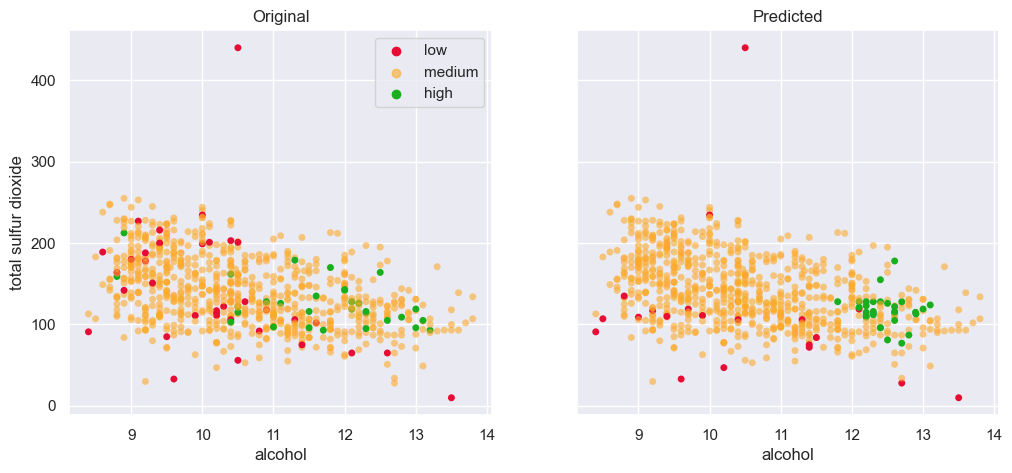

,model name,accuracy,precision,f1 score,recall for HQ,recall for MQ,recall for LQ
0,svc,0.85,0.83,0.84,0.11,0.93,0.48
1,kn,0.82,0.78,0.80,0.10,0.94,0.27
2,r_forest,0.87,0.87,0.87,0.11,0.93,0.37
3,g_boost,0.89,0.90,0.90,0.17,0.93,0.45


In [16]:
model_comparison = model_comparison.iloc[0:0]
predict_quality(ww, 'svc', False, False)
predict_quality(ww, 'kn', False, False)
predict_quality(ww, 'r_forest', False, False)
predict_quality(ww, 'g_boost', False, True)
display(model_comparison)

